## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import preprocess_input as vgg16_preproc
from keras.applications.densenet import preprocess_input as dense_preproc
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

The images and data are stored outside this project and can be downloaded [here](https://www.kaggle.com/nih-chest-xrays/data).

In [4]:
! ls ../p1_data

ARXIV_V5_CHESTXRAY.pdf	images_002  images_008	       README_CHESTXRAY.pdf
BBox_List_2017.csv	images_003  images_009	       test_list.txt
-c			images_004  images_010	       train_val_list.txt
Data_Entry_2017.csv	images_005  images_011
FAQ_CHESTXRAY.pdf	images_006  images_012
images_001		images_007  LOG_CHESTXRAY.pdf


In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('../p1_data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../p1_data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
65784,00016239_002.png,No Finding,2,16239,44,F,PA,2538,2991,0.143,0.143,NaN,../p1_data/images_008/images/00016239_002.png
669,00000174_003.png,No Finding,3,174,73,F,PA,2814,2991,0.143,0.143,NaN,../p1_data/images_001/images/00000174_003.png
54176,00013625_013.png,No Finding,13,13625,63,M,PA,2674,2991,0.143,0.143,NaN,../p1_data/images_006/images/00013625_013.png


In [6]:
## Create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

labels = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
unique_labels = np.unique(list(chain(*labels)))
print(unique_labels)

for ul in unique_labels:
    all_xray_df[ul] = all_xray_df['Finding Labels'].map(lambda findings: 1 if ul in findings else 0)
all_xray_df.sample(10)

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
46353,00011849_000.png,Cardiomegaly,0,11849,74,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
25927,00006816_000.png,No Finding,0,6816,46,F,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
91000,00022680_003.png,No Finding,3,22680,83,F,PA,2470,2457,0.143,...,0,0,0,0,0,1,0,0,0,0
15954,00004232_000.png,No Finding,0,4232,53,M,PA,2048,2500,0.171,...,0,0,0,0,0,1,0,0,0,0
24504,00006446_005.png,No Finding,5,6446,67,M,AP,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
6701,00001803_015.png,Emphysema|Pleural_Thickening,15,1803,58,M,PA,2500,2048,0.168,...,1,0,0,0,0,0,0,1,0,0
44212,00011385_001.png,No Finding,1,11385,60,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
22123,00005857_000.png,No Finding,0,5857,29,F,PA,2048,2500,0.171,...,0,0,0,0,0,1,0,0,0,0
17345,00004655_001.png,No Finding,1,4655,62,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
93072,00023254_005.png,Infiltration,5,23254,49,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,0,0


In [7]:
all_xray_df['Pneumonia Class'] = np.where(all_xray_df.Pneumonia==1, 'Pneumonia', 'No pneumonia')

In [8]:
# prevalence of pneumonia in the dataset
all_xray_df.Pneumonia.sum()/len(all_xray_df) * 100

1.2763110952550838

## Create your training and testing data:

In [9]:
def create_splits(column, test_size=0.2, valid_neg_delta=4):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = test_size, 
                                   stratify = all_xray_df[column])
    ## Split the train_df so that there are equal proportions of pneumonia and no pneumonia in train set
    positive_inds = train_df[train_df.Pneumonia==1].index.tolist()
    negative_inds = train_df[train_df.Pneumonia==0].index.tolist()

    # throw away some negative data 
    # pick positive number of negative cases
    negative_sample = sample(negative_inds, len(positive_inds)) 
    # select all existing positive cases + negative cases (of size positive_inds)
    train_df = train_df.loc[positive_inds + negative_sample] 
    
    ## Split validation set 10-90 (pos-neg)
    positive_inds_valid = valid_df[valid_df.Pneumonia==1].index.tolist()
    negative_inds_valid = valid_df[valid_df.Pneumonia==0].index.tolist()
    
    # negative sample 9x bigger than positive
    negative_sample_valid = sample(negative_inds_valid, valid_neg_delta * len(positive_inds_valid)) 
    valid_df = valid_df.loc[positive_inds_valid + negative_sample_valid]
    
    return train_df, valid_df

In [10]:
train, valid = create_splits('Pneumonia')
train.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia Class
922,00000226_000.png,No Finding,0,226,56,F,PA,2722,2948,0.143,...,0,0,0,0,1,0,0,0,0,No pneumonia
80069,00019665_001.png,Pleural_Thickening,1,19665,49,M,PA,2544,3056,0.139,...,0,0,0,0,0,0,1,0,0,No pneumonia
107161,00028911_003.png,No Finding,3,28911,54,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,No pneumonia
9413,00002439_010.png,Infiltration|Pneumonia,10,2439,65,M,PA,2500,2048,0.171,...,0,0,1,0,0,0,0,1,0,Pneumonia
75262,00018464_027.png,Pneumonia,27,18464,58,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,1,0,Pneumonia


In [11]:
train.Pneumonia.sum()/len(train), valid.Pneumonia.sum()/len(valid)

(0.5, 0.2)

In [12]:
len(train), len(valid)

(2290, 1430)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
target_size = (224, 224)
batch_size = 32

In [16]:
def my_image_augmentation(params):
    my_idg = ImageDataGenerator(**params)
    return my_idg


def make_train_gen(target_size, batch_size, preprocess_input):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    idg = my_image_augmentation({'rescale': 1.0/255.0,
                                'horizontal_flip':True,
                                'vertical_flip':False,
                                'height_shift_range':0.1, 
                                'width_shift_range':0.1, 
                                'rotation_range':10, 
                                'shear_range':0.1,
                                'zoom_range':0.1,
                                'fill_mode':'reflect',
                                'preprocessing_function':preprocess_input}
                               )
    
    train_gen = idg.flow_from_dataframe(dataframe=train, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'Pneumonia',
                                                 class_mode = 'raw',
                                                 shuffle = True,
                                                 target_size = target_size, 
                                                 batch_size = batch_size
                                                )

    return train_gen


def make_val_gen(target_size, batch_size, preprocess_input):
    idg = my_image_augmentation({'rescale': 1.0/255.0,
                                 'preprocessing_function':preprocess_input})
    
    val_gen = idg.flow_from_dataframe(dataframe=valid, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'Pneumonia',
                                                 class_mode = 'raw',
                                                 target_size = target_size, 
                                                 batch_size = 512
                                                )
    
    return val_gen

In [17]:
train_gen = make_train_gen(target_size, batch_size, vgg16_preproc) 
val_gen = make_val_gen(target_size, batch_size, vgg16_preproc)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [18]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [19]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
print("shape", t_x[0].shape)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

Lets plot the intensity histograms for the above images. We see they vary a lot, with no clear differentiating intensity. At most one can maybe say pneumonia is _sometimes_ more intense.

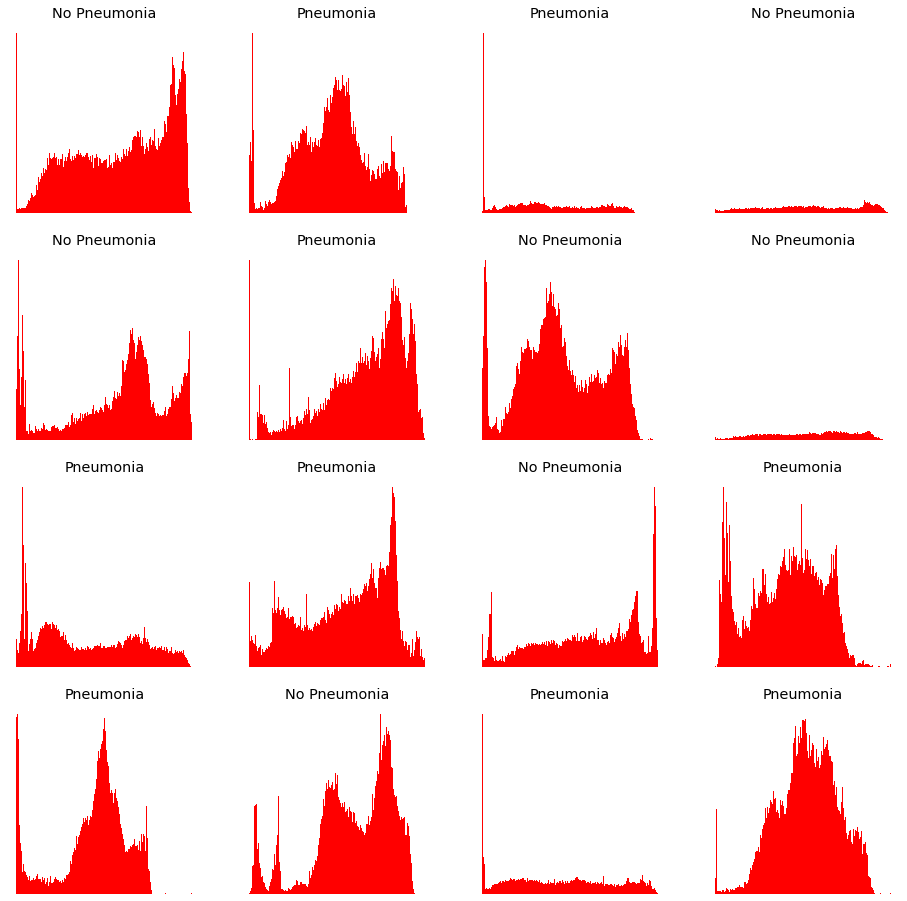

In [109]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.hist(c_x[:,:,0].flatten(), bins=256, color = 'red')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [4]:
# 'block5_conv3'

In [110]:
def load_pretrained_vgg16():
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    return vgg_model
    

def load_pretrained_densenet():
    model = DenseNet121(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('avg_pool')
    dense_model = Model(inputs=model.input, outputs = transfer_layer.output)
    
    for layer in dense_model.layers[:-1]:
        layer.trainable = False
    
    return dense_model
    
pretrained_dense = load_pretrained_densenet()
pretrained_vgg16 = load_pretrained_vgg16()

In [111]:
def compile(model, lr):
    ## Set the optimizer, loss function, and learning rate
    optimizer = Adam(lr=lr)
    loss = 'binary_crossentropy' # 2 classes, pos/neg for pneumonia 
    metrics = ['binary_accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def build_model(pretrained_model, list_of_layers, model_type, lr=1e-4, dropout=0.25):    
    model = Sequential()
    if pretrained_model:
        model.add(pretrained_model)
    
    if model_type == 'vgg16':
        model.add(Flatten())
        model.add(Dropout(dropout))
    
        for i, layer_nodes in enumerate(list_of_layers):
            last_layer = i == (len(list_of_layers) - 1)
            activation = 'sigmoid' if last_layer else 'relu'
            model.add(Dense(layer_nodes, activation=activation))
            if not last_layer:
                model.add(Dropout(dropout))
    
    if model_type == 'dense':
        for i, layer_nodes in enumerate(list_of_layers):
            last_layer = i == (len(list_of_layers) - 1)
            activation = 'sigmoid' if last_layer else 'relu'
            model.add(Dense(layer_nodes, activation=activation))

    model = compile(model, lr)
    
    return model

In [112]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


weight_path_vgg="{}_my_model_vgg.best.hdf5".format('xray_class')
weight_path_dense="{}_my_model_dense.best.hdf5".format('xray_class')

checkpoint_vgg = ModelCheckpoint(weight_path_vgg, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='min', 
                              save_weights_only = True)

checkpoint_dense = ModelCheckpoint(weight_path_dense, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='min', 
                              save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.175,
                              patience=3, min_lr=1e-5)

callbacks_list_vgg = [checkpoint_vgg, early, reduce_lr]
callbacks_list_dense = [checkpoint_dense, early, reduce_lr]

### Start training! 

In [113]:
history_vgg = None
try:
    model_vgg = build_model(pretrained_vgg16, list_of_layers=[1024, 512, 256, 1], lr=0.0001, dropout=0.4, model_type='vgg16')
    model_vgg.summary()
    
    history_vgg = model_vgg.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list_vgg,
                          steps_per_epoch = len(train_gen))
except KeyboardInterrupt:
    print('\n\nTraining interrupted.')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)              

In [ ]:
# further training of the last convolutional layer


In [114]:
history_dense = None
try:
    model_dense = build_model(pretrained_dense, list_of_layers=[1], lr=0.0005, model_type='dense')
    model_dense.summary()
    
    history_dense = model_dense.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30, 
                          callbacks = callbacks_list_dense,
                          steps_per_epoch = len(train_gen),
                          validation_steps= len(val))
except KeyboardInterrupt:
    print('\n\nTraining interrupted.')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 1024)              7037504   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/30
72/72 [==============================] - 63s 882ms/step - loss: 0.7628 - binary_accuracy: 0.4965 - val_loss: 0.7681 - val_binary_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 0.76805, saving model to xray_class_my_model_dense.best.hdf5
Epoch 2/30
72/72 [==============================] - 54s 748ms/step - loss: 0.6992 - binary_accuracy: 0.5546 - val_loss: 0.5814 - val_binary_accuracy: 0.7600

Epoch 00002: val_loss improved from 0.76805 to 0.58144, saving model to xray_class

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [135]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model_vgg.load_weights(weight_path_vgg)
pred_Y = model_vgg.predict(valX, batch_size = 32, verbose = True)

model_dense.load_weights(weight_path_dense)
pred_Y_dense = model_dense.predict(valX, batch_size = 32, verbose = True)

100/100 [==============================] - 5s 51ms/step


In [136]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

def plot_precision_recall(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return precision, recall, thresholds

def f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)
    
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

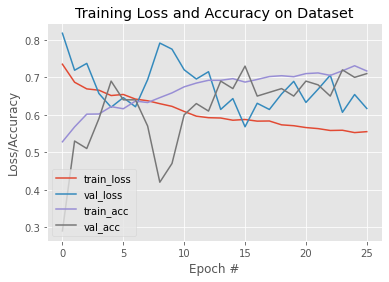

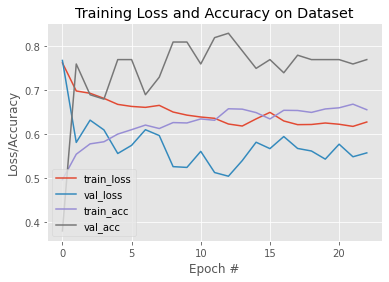

In [137]:
## plot figures
plot_history(history_vgg)
plot_history(history_dense)

No handles with labels found to put in legend.


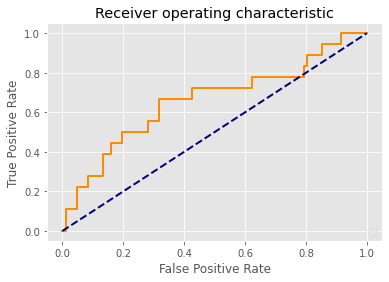

No handles with labels found to put in legend.


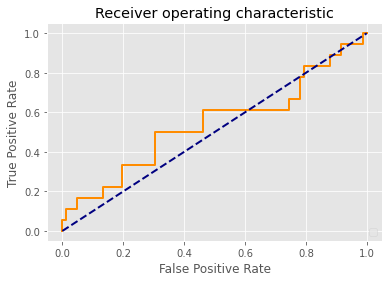

In [138]:
plot_auc(valY, pred_Y);
plot_auc(valY, pred_Y_dense);

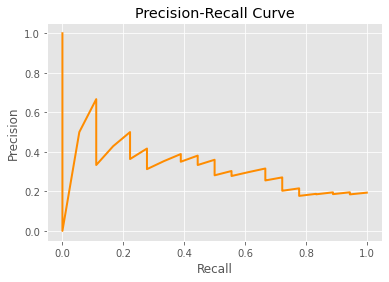

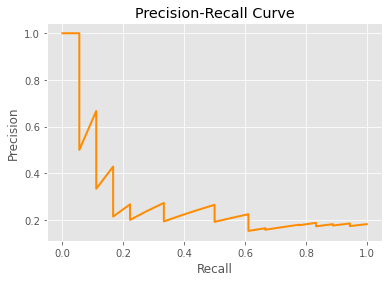

In [140]:
precision, recall, thresholds = plot_precision_recall(valY, pred_Y)
precision_dense, recall_dense, thresholds_dense = plot_precision_recall(valY, pred_Y_dense)

[Text(0, 0.5, 'precision/recall'),
 Text(0.5, 0, 'threshold'),
 Text(0.5, 1.0, 'Dense 121')]

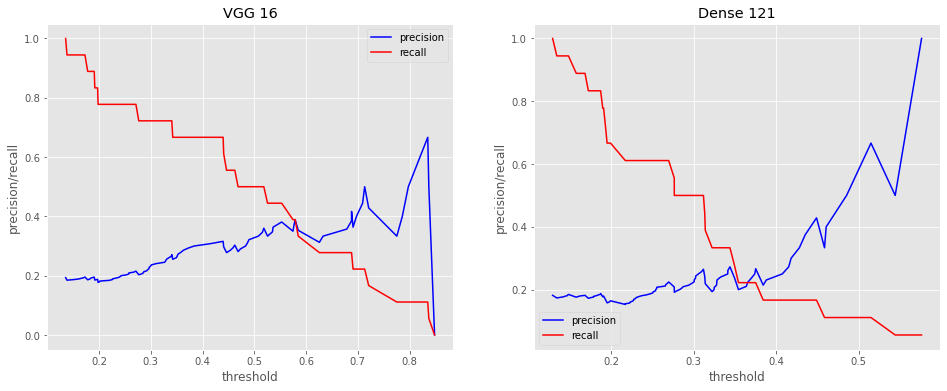

In [156]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.plot(thresholds, precision[:-1], color='blue', label="precision")
ax1.plot(thresholds, recall[:-1], color='red', label="recall")

ax2.plot(thresholds_dense, precision_dense[:-1], color='blue', label="precision")
ax2.plot(thresholds_dense, recall_dense[:-1], color='red', label="recall")

ax1.legend()
ax2.legend()

ax1.set(xlabel='threshold', ylabel="precision/recall", title="VGG 16")
ax2.set(xlabel='threshold', ylabel="precision/recall", title="Dense 121")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


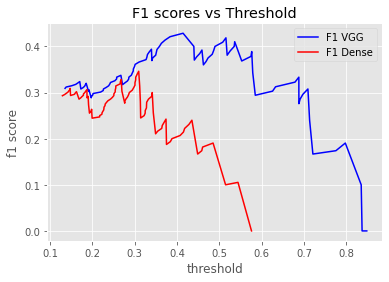

In [154]:
import math
# F1 scores by threshold using above thresholds, precision, and recall values
def calc_f1_scores(thresholds, precision, recall):
    def find_threshold_and_calc(cur_th):
        for i, th in enumerate(thresholds):
            if th > cur_th:
                f1_score = f1(precision[i], recall[i])
                if not math.isnan(f1_score):
                    return f1_score
                else:
                    return 0
        return 0
    return [find_threshold_and_calc(cur_th) for cur_th in thresholds]
    

f1_scores = calc_f1_scores(thresholds, precision, recall)
f1_scores_dense = calc_f1_scores(thresholds_dense, precision_dense, recall_dense)
plt.plot(thresholds, f1_scores, color='blue', label='F1 VGG')
plt.plot(thresholds_dense, f1_scores_dense, color='red', label='F1 Dense')
plt.xlabel('threshold')
plt.ylabel('f1 score')
plt.title('F1 scores vs Threshold')
plt.legend()

In [188]:
# maximum F1 scores
f1_vgg = f1_scores[np.argmax(f1_scores)]
f1_dense = f1_scores_dense[np.argmax(f1_scores_dense)]
f1_vgg, f1_dense

(0.42857142857142855, 0.3461538461538462)

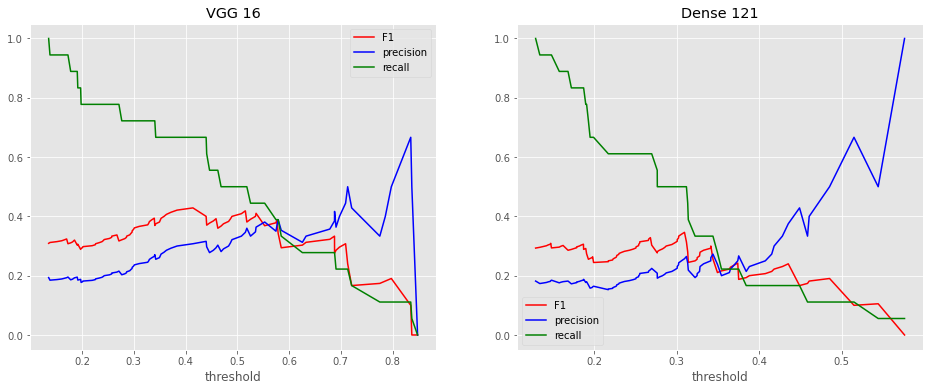

In [196]:
# f1, recall, precision vs thresholds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.plot(thresholds, f1_scores, color='red', label='F1')
ax1.plot(thresholds, precision[:-1], color='blue', label='precision')
ax1.plot(thresholds, recall[:-1], color='green', label='recall')

ax1.set(xlabel='threshold', title='VGG 16')
ax1.legend()

ax2.plot(thresholds_dense, f1_scores_dense, color='red', label='F1')
ax2.plot(thresholds_dense, precision_dense[:-1], color='blue', label='precision')
ax2.plot(thresholds_dense, recall_dense[:-1], color='green', label='recall')
ax2.set(xlabel='threshold', title='Dense 121')
ax2.legend()

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide).

In [194]:
vgg_threshold = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
for t in vgg_threshold:
    tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > t).astype(int)).ravel()
    print(f'Threshold: {t}.. True neg: {tn}; True pos: {tp}; False neg: {fn}; False pos: {fp}')

Threshold: 0.2.. True neg: 18; True pos: 14; False neg: 4; False pos: 64
Threshold: 0.25.. True neg: 27; True pos: 14; False neg: 4; False pos: 55
Threshold: 0.3.. True neg: 40; True pos: 13; False neg: 5; False pos: 42
Threshold: 0.35.. True neg: 49; True pos: 12; False neg: 6; False pos: 33
Threshold: 0.4.. True neg: 55; True pos: 12; False neg: 6; False pos: 27
Threshold: 0.45.. True neg: 57; True pos: 10; False neg: 8; False pos: 25


In [178]:
dense_threshold = [0.15, 0.25, 0.28, 0.3, 0.33, 0.35, 0.4]
for t in dense_threshold:
    tn, fp, fn, tp = confusion_matrix(valY, (pred_Y_dense > t).astype(int)).ravel()
    print(f'Threshold: {t}.. True neg: {tn}; True pos: {tp}; False neg: {fn}; False pos: {fp}')

Threshold: 0.15.. True neg: 7; True pos: 16; False neg: 2; False pos: 75
Threshold: 0.25.. True neg: 35; True pos: 11; False neg: 7; False pos: 47
Threshold: 0.28.. True neg: 46; True pos: 9; False neg: 9; False pos: 36
Threshold: 0.3.. True neg: 51; True pos: 9; False neg: 9; False pos: 31
Threshold: 0.33.. True neg: 63; True pos: 6; False neg: 12; False pos: 19
Threshold: 0.35.. True neg: 66; True pos: 4; False neg: 14; False pos: 16
Threshold: 0.4.. True neg: 73; True pos: 3; False neg: 15; False pos: 9


In [182]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification.

YOUR_THRESHOLD = 0.4
testY = valY

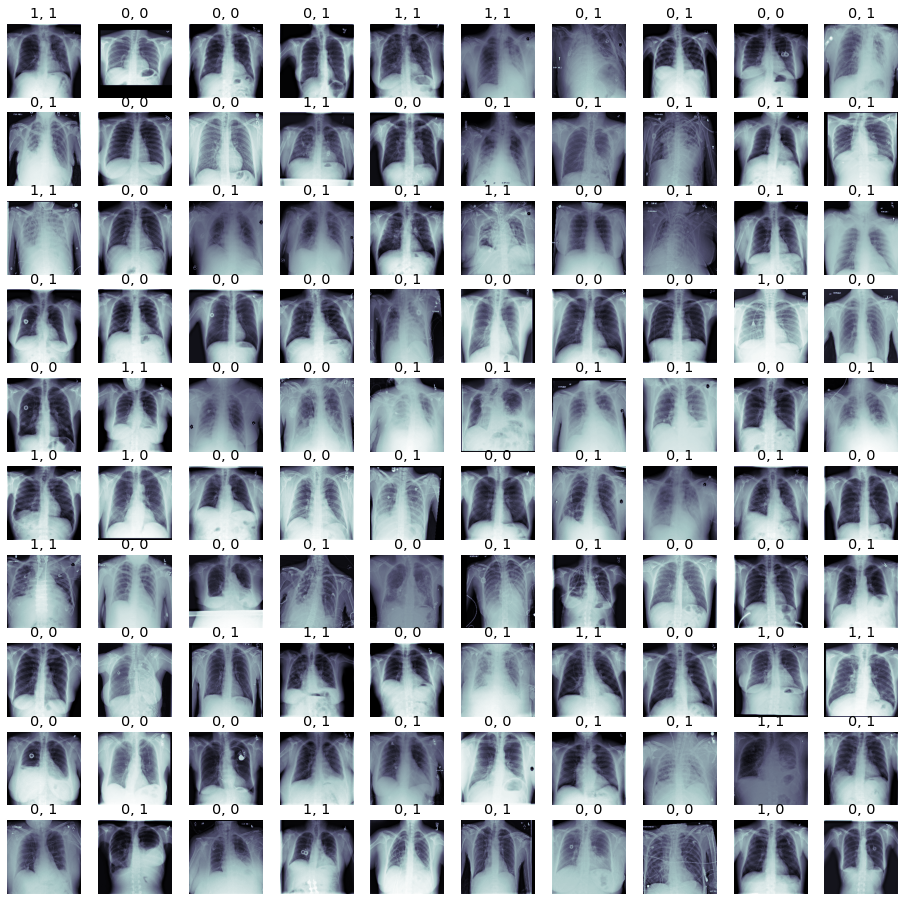

In [197]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [198]:
## Just save model architecture to a .json:

model_json = model_vgg.to_json()
with open("model_vgg.json", "w") as json_file:
    json_file.write(model_json)

In [199]:
## Just save model architecture to a .json:

model_json_dense = model_dense.to_json()
with open("model_dense.json", "w") as json_file:
    json_file.write(model_json_dense)